<a href="https://colab.research.google.com/github/RashmiBhagya/Transfer-Leaning-With-Image-Clasifier-Banana-Detection/blob/main/banana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install tensorflow -q

!pip install opendatasets -q



In [ ]:
# import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import opendatasets as od

Load Dataset

In [ ]:
# download dataset
od.download("https://www.kaggle.com/datasets/rashmipremadasa/healthy-banana-identify-dataset-chemical-or-not")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rashmipremadasa
Your Kaggle Key: ··········


100%|██████████| 1.80G/1.80G [00:23<00:00, 84.1MB/s]


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (256,256)

In [ ]:
train_data_dir = "/content/healthy-banana-identify-dataset-chemical-or-not/Banana/Banana/Banana/Test"
test_data_dir = "/content/healthy-banana-identify-dataset-chemical-or-not/Banana/Banana/Banana/Train"


In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='training',
                                                         validation_split=0.1,
                                                         seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='validation',
                                                         validation_split=0.1,
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

Found 337 files belonging to 2 classes.
Using 304 files for training.
Found 337 files belonging to 2 classes.
Using 33 files for validation.
Found 1627 files belonging to 2 classes.


In [ ]:
class_names = train_data.class_names
class_names

['Chemical', 'Non-Chemical']

In [ ]:
for image_batch,label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 256, 256, 3)
(32,)


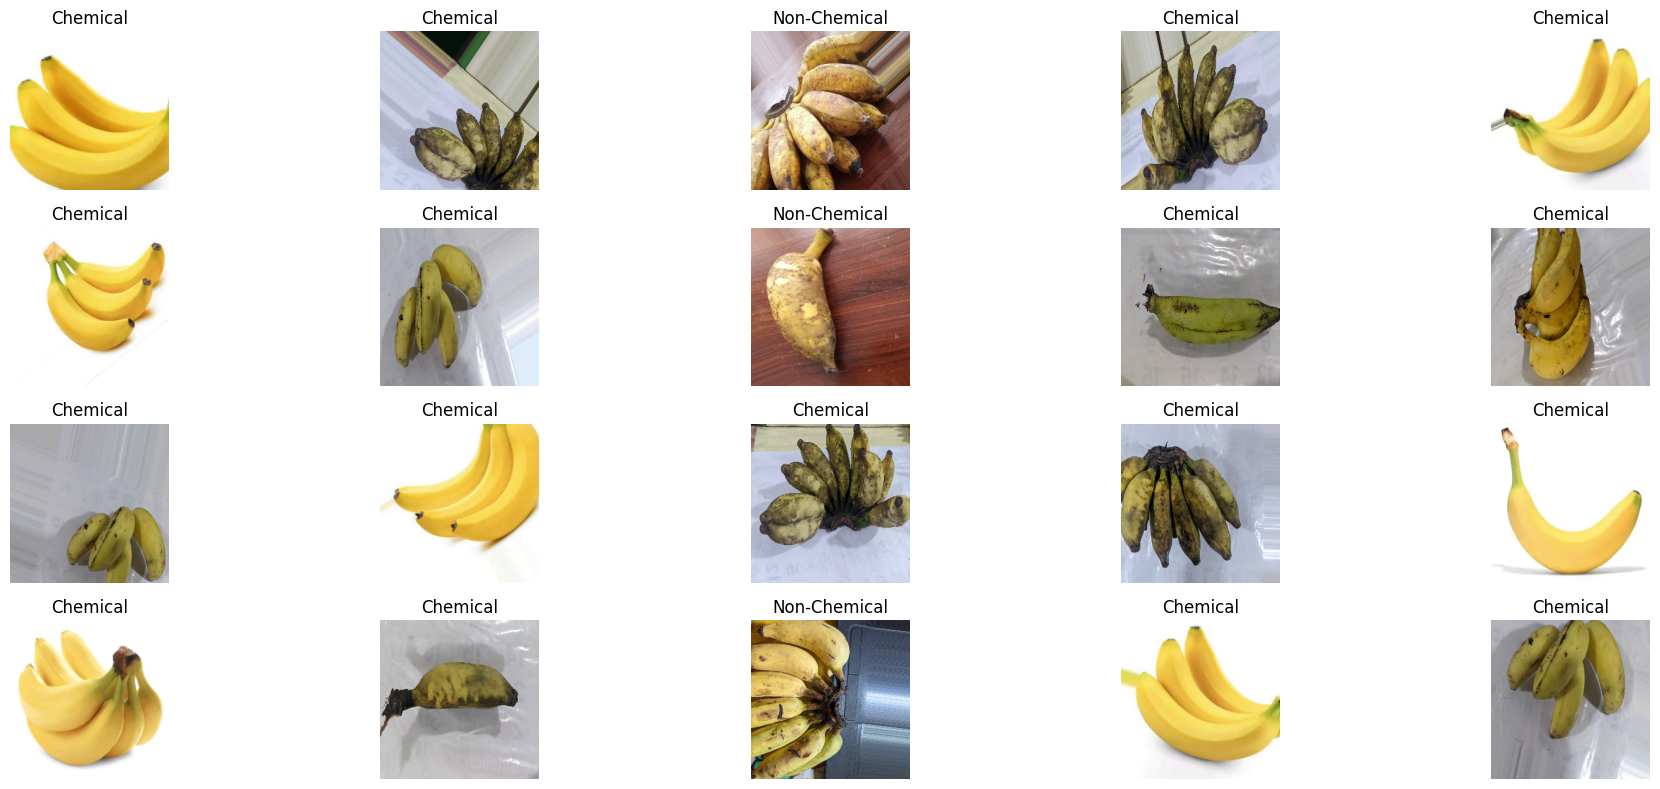

In [ ]:
import matplotlib.pyplot as plt

# Plot data sample
plt.figure(figsize=(20, 8))
for image, label in train_data.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i+1)  # Adjusted to 4 rows and 5 columns
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

plt.tight_layout()
plt.show()


Scaling Images


In [ ]:
for image,label in train_data.take(1):
    for i in range(1):
      print(image)

tf.Tensor(
[[[[255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   ...
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]]

  [[255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   ...
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]]

  [[255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   ...
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]]

  ...

  [[255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   ...
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]]

  [[255.       255.       255.    

In [ ]:
train_data = train_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))

In [ ]:
for image,label in train_data.take(1):
    for i in range(1):
      print(image)

tf.Tensor(
[[[[0.8156863  0.6431373  0.6       ]
   [0.8        0.627451   0.58431375]
   [0.76875    0.596201   0.55306375]
   ...
   [0.52953434 0.35306373 0.3334559 ]
   [0.5734069  0.3985294  0.3702206 ]
   [0.62328434 0.4507353  0.4154412 ]]

  [[0.8159314  0.6433824  0.6002451 ]
   [0.81102943 0.63848037 0.5953431 ]
   [0.7948529  0.6223039  0.57916665]
   ...
   [0.6194853  0.43517157 0.3959559 ]
   [0.54178923 0.36139706 0.31041667]
   [0.5422794  0.36188725 0.31090686]]

  [[0.8020833  0.6295343  0.58639705]
   [0.8156863  0.6431373  0.6       ]
   [0.80784315 0.63529414 0.5921569 ]
   ...
   [0.61335784 0.421201   0.36629903]
   [0.6383578  0.44620097 0.3841912 ]
   [0.6544118  0.46409315 0.39191177]]

  ...

  [[0.50980395 0.3019608  0.27058825]
   [0.5262255  0.31838235 0.2870098 ]
   [0.54509807 0.3372549  0.30588236]
   ...
   [0.41703433 0.15428922 0.08762255]
   [0.42046568 0.1577206  0.09105392]
   [0.42169118 0.15894608 0.09227941]]

  [[0.53333336 0.32941177 0.278431

Transfer Learning

In [ ]:
pretrained_model = tf.keras.applications.xception.Xception(include_top=False,
                                                           input_shape=(256,256,3),
                                                           weights="imagenet",
                                                           pooling='max')

for layer in pretrained_model.layers:
        layer.trainable=False

83683744/83683744 [==============================] - 0s 0us/step


Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(256,256,3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
  ]
)

Model Building

In [ ]:
model = tf.keras.models.Sequential()

model.add(pretrained_model)

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21144425 (80.66 MB)
Trainable params: 28

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

Model Training

In [ ]:
start_time = time.time()

history = model.fit(train_data,
                    epochs=5,
                    validation_data=validation_data)

end_time = time.time()

Epoch 1/5
10/10 [==============================] - 27s 690ms/step - loss: 0.6293 - accuracy: 0.6711 - val_loss: 0.4194 - val_accuracy: 0.8788
Epoch 2/5
10/10 [==============================] - 12s 403ms/step - loss: 0.2967 - accuracy: 0.8750 - val_loss: 0.3476 - val_accuracy: 0.9091
Epoch 3/5
10/10 [==============================] - 14s 470ms/step - loss: 0.1317 - accuracy: 0.9572 - val_loss: 0.1612 - val_accuracy: 0.9394
Epoch 4/5
10/10 [==============================] - 13s 330ms/step - loss: 0.0666 - accuracy: 0.9803 - val_loss: 0.1330 - val_accuracy: 0.9091
Epoch 5/5
10/10 [==============================] - 13s 331ms/step - loss: 0.0292 - accuracy: 0.9934 - val_loss: 0.0465 - val_accuracy: 0.9697


In [ ]:
print(f'Total time for training {(end_time-start_time):.3f} seconds')

Total time for training 110.363 seconds


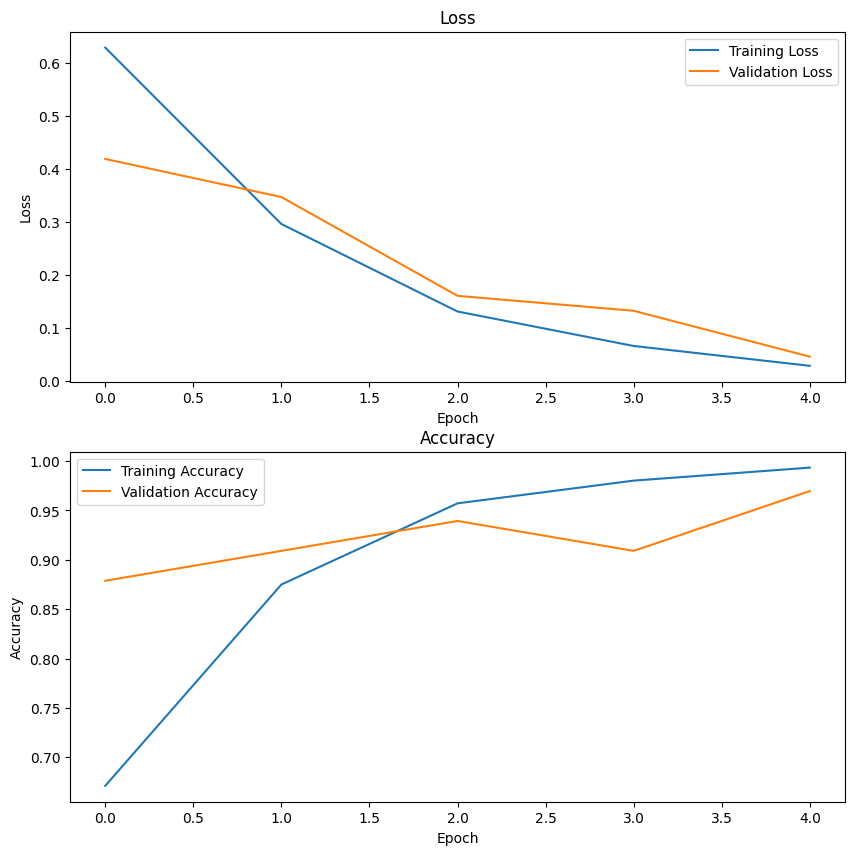

In [ ]:
# Plot loss and accuracy
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

In [ ]:
# Model evaluation
y_true = []
y_pred = []

for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    y_true.extend(y)
    y_pred.extend(yhat > 0.5)


1/1 [==============================] - 0s 33ms/step


In [ ]:
!pip install scikit-learn -q

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
import seaborn as sns

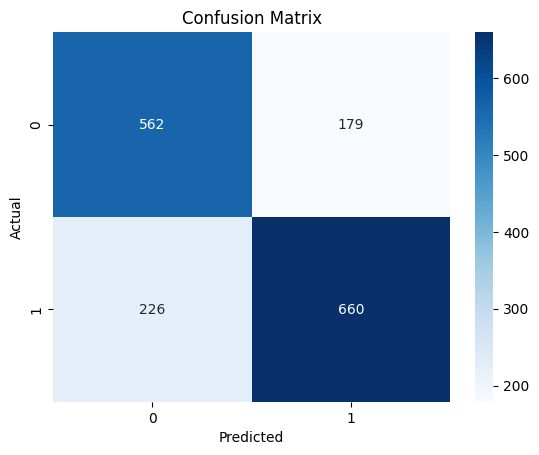

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# RGB Histogram
def plot_rgb_histogram(image):
   if image is None:
       print("Error: Image not found or unable to read.")
       return

   colors = ('r', 'g', 'b')
   for i, color in enumerate(colors):
       hist = cv2.calcHist([image], [i], None, [256], [0, 256])
       plt.plot(hist, color=color)
       plt.xlim([0, 256])
   plt.xlabel('Bins')
   plt.ylabel('Frequency')
   plt.title('RGB Histogram')
   plt.show()

In [ ]:
!pip install opencv-python -q

In [ ]:
import cv2

In [ ]:
# Load sample images
chemical_image = cv2.imread('/content/healthy-banana-identify-dataset-chemical-or-not/Banana/Banana/Banana/Test/Chemical/PXL_20240128_150408926.jpg')
non_chemical_image = cv2.imread('/content/healthy-banana-identify-dataset-chemical-or-not/Banana/Banana/Banana/Test/Non-Chemical/PXL_20240124_071751414.jpg')

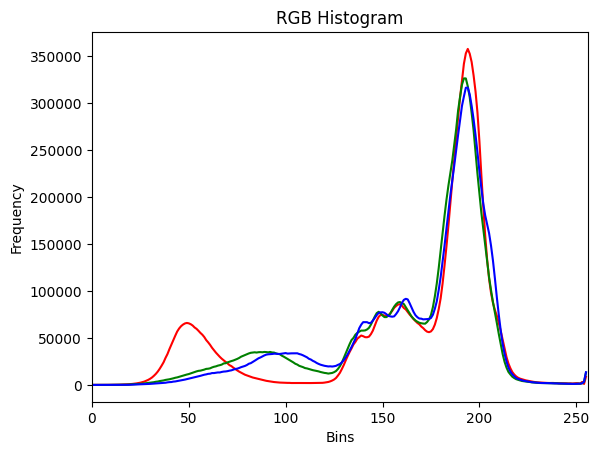

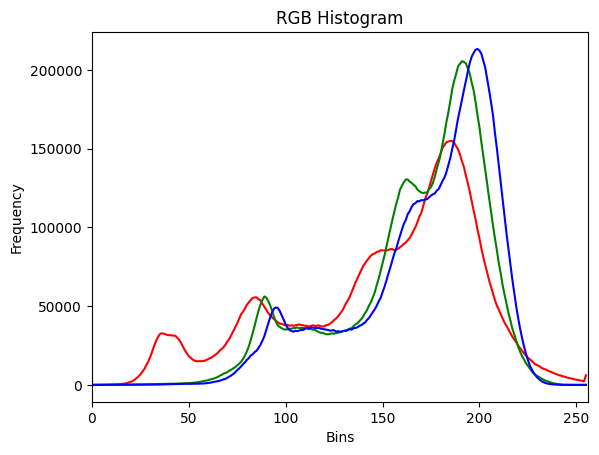

In [ ]:
# Plot RGB histograms
plot_rgb_histogram(chemical_image)
plot_rgb_histogram(non_chemical_image)

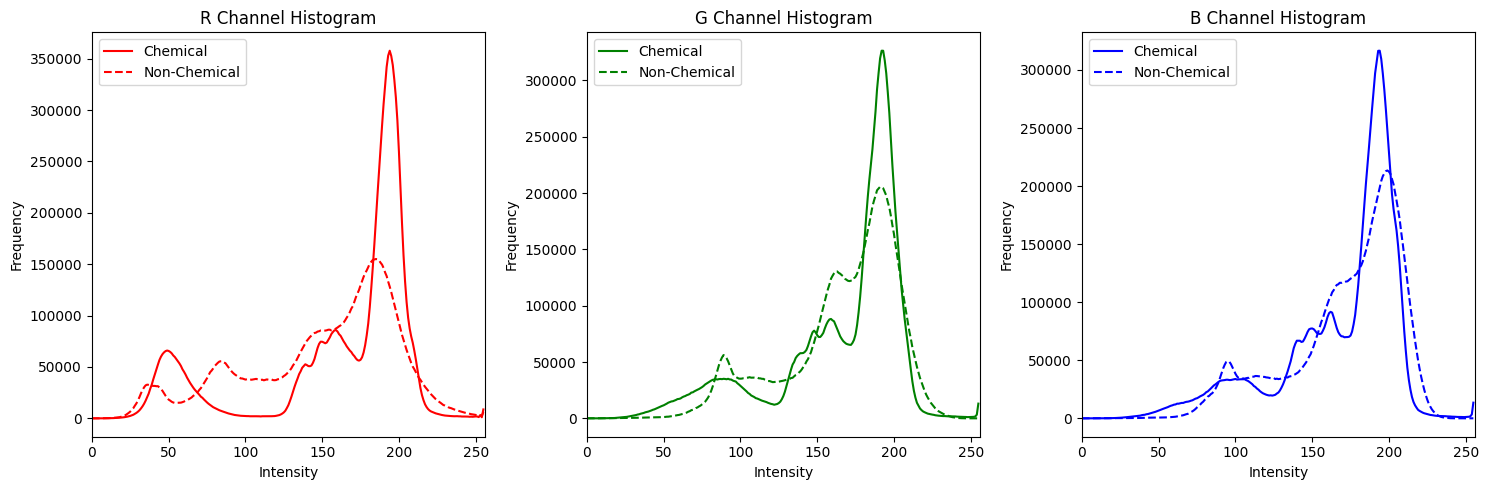

In [ ]:
# RGB Histogram comparison
def plot_rgb_histogram_comparison(image1, image2, label1='Chemical', label2='Non-Chemical'):
    if image1 is None or image2 is None:
        print("Error: Image not found or unable to read.")
        return

    colors = ('r', 'g', 'b')
    plt.figure(figsize=(15, 5))

    for i, color in enumerate(colors):
        hist1 = cv2.calcHist([image1], [i], None, [256], [0, 256])
        hist2 = cv2.calcHist([image2], [i], None, [256], [0, 256])

        plt.subplot(1, 3, i+1)
        plt.plot(hist1, color=color, label=label1)
        plt.plot(hist2, color=color, linestyle='--', label=label2)
        plt.xlim([0, 256])
        plt.xlabel('Intensity')
        plt.ylabel('Frequency')
        plt.title(f'{color.upper()} Channel Histogram')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plot RGB histogram comparison for chemical and non-chemical bananas
plot_rgb_histogram_comparison(chemical_image, non_chemical_image)


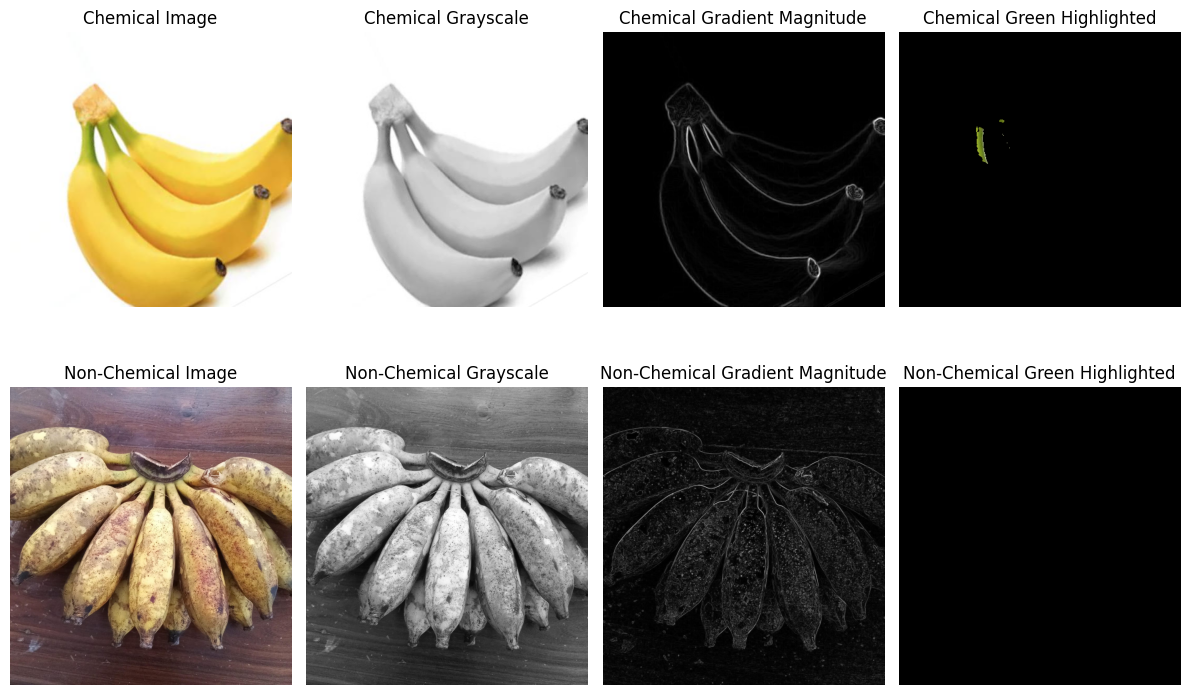

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the chemical and non-chemical images
chemical_image = cv2.imread('/content/augmentated_0_5023.jpeg')
non_chemical_image = cv2.imread('/content/1.jpeg')



# Convert images to grayscale
chemical_gray = cv2.cvtColor(chemical_image, cv2.COLOR_BGR2GRAY)
non_chemical_gray = cv2.cvtColor(non_chemical_image, cv2.COLOR_BGR2GRAY)

# Calculate image gradients (Sobel)
chemical_gradient_x = cv2.Sobel(chemical_gray, cv2.CV_64F, 1, 0, ksize=3)
chemical_gradient_y = cv2.Sobel(chemical_gray, cv2.CV_64F, 0, 1, ksize=3)
non_chemical_gradient_x = cv2.Sobel(non_chemical_gray, cv2.CV_64F, 1, 0, ksize=3)
non_chemical_gradient_y = cv2.Sobel(non_chemical_gray, cv2.CV_64F, 0, 1, ksize=3)

# Calculate gradient magnitude
chemical_gradient_magnitude = np.sqrt(chemical_gradient_x**2 + chemical_gradient_y**2)
non_chemical_gradient_magnitude = np.sqrt(non_chemical_gradient_x**2 + non_chemical_gradient_y**2)

# Apply color segmentation to highlight differences
chemical_hsv = cv2.cvtColor(chemical_image, cv2.COLOR_BGR2HSV)
non_chemical_hsv = cv2.cvtColor(non_chemical_image, cv2.COLOR_BGR2HSV)

# Define color thresholds for segmentation
lower_green = np.array([35, 50, 50])
upper_green = np.array([90, 255, 255])

# Create masks for green regions in the images
chemical_mask = cv2.inRange(chemical_hsv, lower_green, upper_green)
non_chemical_mask = cv2.inRange(non_chemical_hsv, lower_green, upper_green)

# Apply masks to original images
chemical_green_highlighted = cv2.bitwise_and(chemical_image, chemical_image, mask=chemical_mask)
non_chemical_green_highlighted = cv2.bitwise_and(non_chemical_image, non_chemical_image, mask=non_chemical_mask)

# Plot the images and their processed versions
plt.figure(figsize=(12, 8))

plt.subplot(2, 4, 1)
plt.imshow(cv2.cvtColor(chemical_image, cv2.COLOR_BGR2RGB))
plt.title('Chemical Image')
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(chemical_gray, cmap='gray')
plt.title('Chemical Grayscale')
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(chemical_gradient_magnitude, cmap='gray')
plt.title('Chemical Gradient Magnitude')
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(cv2.cvtColor(chemical_green_highlighted, cv2.COLOR_BGR2RGB))
plt.title('Chemical Green Highlighted')
plt.axis('off')

plt.subplot(2, 4, 5)
plt.imshow(cv2.cvtColor(non_chemical_image, cv2.COLOR_BGR2RGB))
plt.title('Non-Chemical Image')
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(non_chemical_gray, cmap='gray')
plt.title('Non-Chemical Grayscale')
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(non_chemical_gradient_magnitude, cmap='gray')
plt.title('Non-Chemical Gradient Magnitude')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(cv2.cvtColor(non_chemical_green_highlighted, cv2.COLOR_BGR2RGB))
plt.title('Non-Chemical Green Highlighted')
plt.axis('off')

plt.tight_layout()
plt.show()


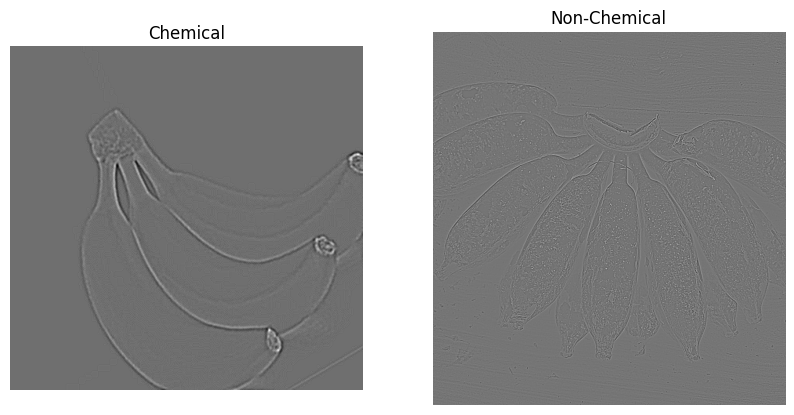

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the chemical and non-chemical images
chemical_image = cv2.imread('/content/augmentated_0_5023.jpeg', cv2.IMREAD_GRAYSCALE)
non_chemical_image = cv2.imread('/content/1.jpeg', cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise
chemical_blurred = cv2.GaussianBlur(chemical_image, (5, 5), 0)
non_chemical_blurred = cv2.GaussianBlur(non_chemical_image, (5, 5), 0)

# Apply Laplacian filter for edge detection
chemical_edges = cv2.Laplacian(chemical_blurred, cv2.CV_64F)
non_chemical_edges = cv2.Laplacian(non_chemical_blurred, cv2.CV_64F)

# Enhance contrast
chemical_edges = cv2.normalize(chemical_edges, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
non_chemical_edges = cv2.normalize(non_chemical_edges, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Plot the chemical and non-chemical edge images with black color
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(chemical_edges, cmap='gray')
plt.title('Chemical')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_chemical_edges, cmap='gray')
plt.title('Non-Chemical')
plt.axis('off')

plt.show()


Performance Analysis

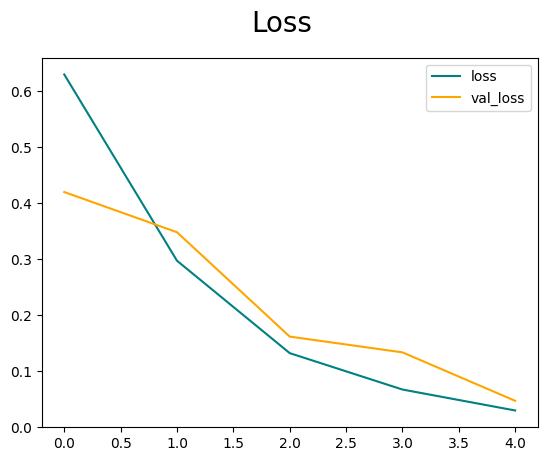

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

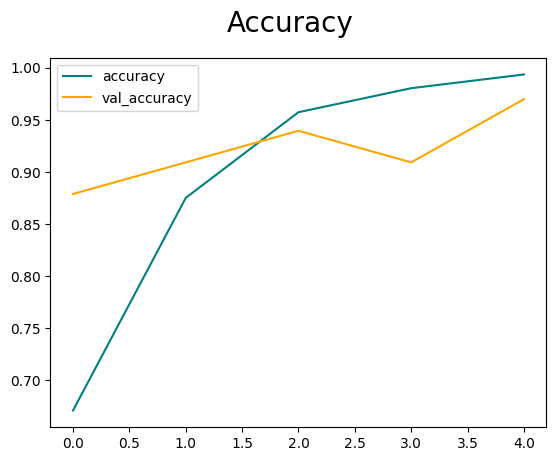

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

Model Evaluation

In [ ]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

In [ ]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 33ms/step


In [ ]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.7866508>

In [ ]:
recall.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.74492097>

In [ ]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.7510756>

Test

In [ ]:
!pip install opencv-python -q

In [ ]:
import cv2

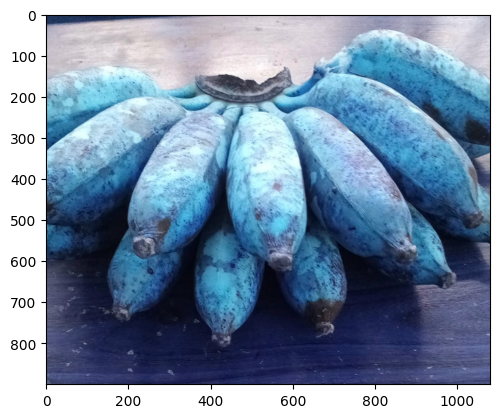

In [ ]:
image = cv2.imread('/content/healthy-banana-identify-dataset-chemical-or-not/Banana/Banana/Banana/Test/Non-Chemical/3.jpeg')
plt.imshow(image)
plt.show()

In [ ]:
resized_image = tf.image.resize(image, IMAGE_SIZE)
scaled_image = resized_image/255


In [ ]:
scaled_image.shape

TensorShape([256, 256, 3])

In [ ]:
np.expand_dims(scaled_image, 0).shape

(1, 256, 256, 3)

In [ ]:
yhat = model.predict(np.expand_dims(scaled_image, 0))

1/1 [==============================] - 0s 111ms/step


In [ ]:
yhat

array([[0.9994331]], dtype=float32)

In [ ]:
class_names

['Chemical', 'Non-Chemical']

In [ ]:
if yhat > 0.5:
    print(f'{class_names[1]}')
else:
    print(f'{class_names[0]}')


Non-Chemical


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)